### Import Libraries

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import os

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [17]:
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
DATASET_PATH ='/content/drive/MyDrive/project/PRCP-1001-RiceLeaf/Data'

### Function to check dataset path and class folders

In [18]:
def check_dataset(DATASET_PATH):
    if not os.path.exists(DATASET_PATH):
        raise FileNotFoundError(f"Dataset path not found: {DATASET_PATH}")

    classes = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
    if not classes:
        raise Exception("No class folders found in dataset path!")

    print("Classes found:", classes)

    # Count images in each class folder

    valid_extensions = ['.jpg', '.jpeg', '.png','.JPG']
    for c in classes:
        class_path = os.path.join(DATASET_PATH, c)
        num_images = len([
            f for f in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, f)) and os.path.splitext(f)[1].lower() in valid_extensions
        ])
        print(f"{c} -> {num_images} images")

    return classes
classes = check_dataset(DATASET_PATH)

Classes found: ['train', 'val', 'test']
train -> 0 images
val -> 0 images
test -> 0 images


### Create ImageDataGenerators for training and validation

In [19]:
def create_generators(dataset_path):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=VALIDATION_SPLIT,
        # Added augmentation
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_gen = datagen.flow_from_directory(
        dataset_path,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        seed=seed
    )

    val_gen = datagen.flow_from_directory(
        dataset_path,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        seed=seed
    )

    print("Class mapping:", train_gen.class_indices)
    return train_gen, val_gen

train_gen, val_gen = create_generators(DATASET_PATH)

Found 224 images belonging to 3 classes.
Found 54 images belonging to 3 classes.
Class mapping: {'test': 0, 'train': 1, 'val': 2}


### Visualizing training data images with their class names

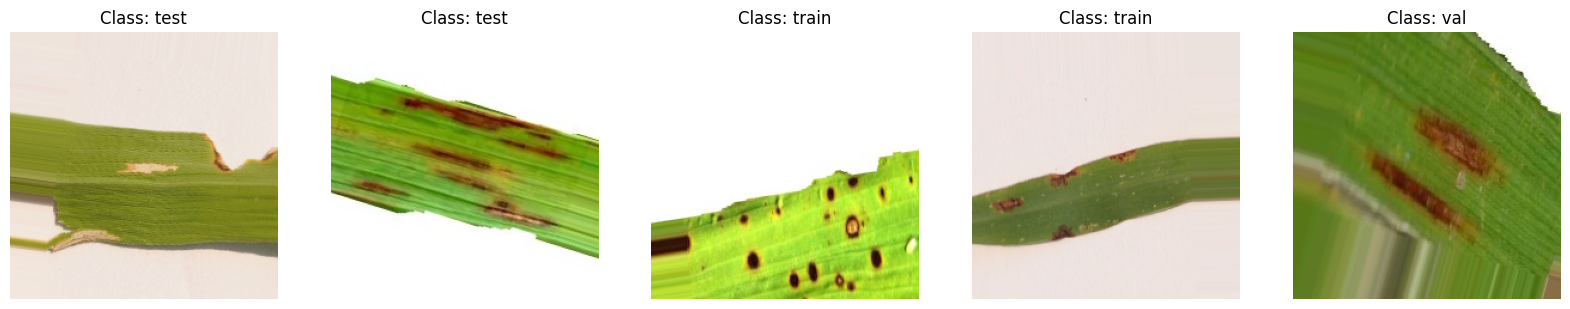

In [20]:
def visualize_samples(train_gen):
    index_to_class = {v: k for k, v in train_gen.class_indices.items()}
    images, labels = next(train_gen)

    fig, axes = plt.subplots(1, 5, figsize=(20,5))
    for i in range(5):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Class: {index_to_class[labels[i].argmax()]}")
        axes[i].axis('off')
    plt.show()
visualize_samples(train_gen)


### Visualizing validation data images with their class names

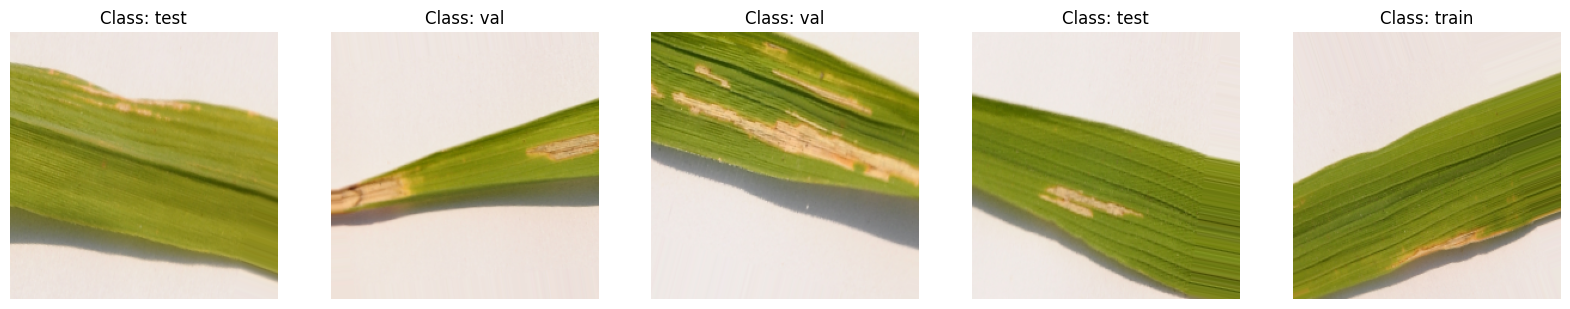

In [21]:
def visualize_samples(val_gen):
    index_to_class = {v: k for k, v in val_gen.class_indices.items()}
    images, labels = next(val_gen)

    fig, axes = plt.subplots(1, 5, figsize=(20,5))
    for i in range(5):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Class: {index_to_class[labels[i].argmax()]}")
        axes[i].axis('off')
    plt.show()
visualize_samples(val_gen)

#Check for class imbalance

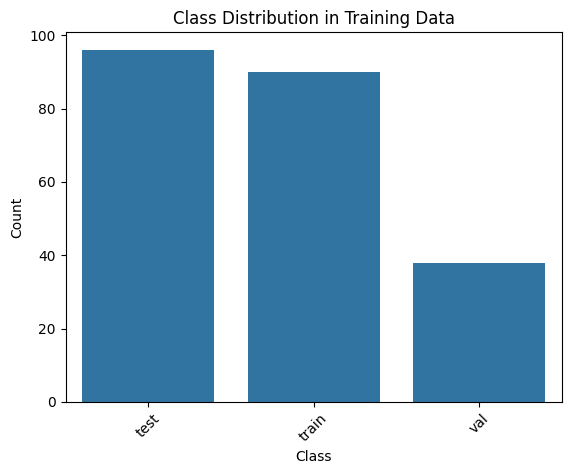

In [22]:
import pandas as pd
import seaborn as sns

class_counts = {k: 0 for k in train_gen.class_indices.keys()}

for c, idx in train_gen.class_indices.items():
    class_counts[c] = sum(train_gen.labels == idx)

df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
sns.barplot(data=df, x='Class', y='Count')
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=45)
plt.show()

## Check image shapes and types

In [23]:

images,lables = next(train_gen)
print("Train Image batch shape:", images.shape)
print("Train Image data type:", images.dtype)

images,lables = next(val_gen)
print("Validation Image batch shape:", images.shape)
print("Validation Image data type:", images.dtype)

Train Image batch shape: (32, 224, 224, 3)
Train Image data type: float32
Validation Image batch shape: (22, 224, 224, 3)
Validation Image data type: float32


### Display multiple batches of training data to see augmentation effects

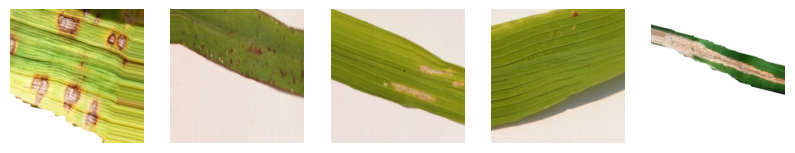

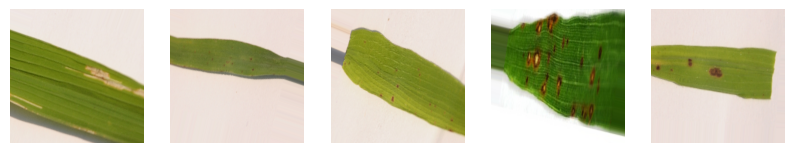

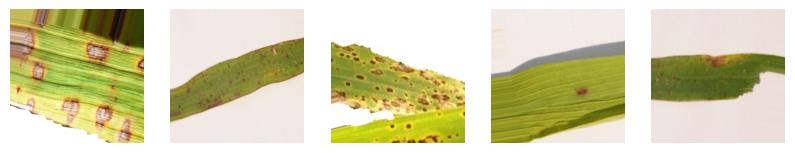

In [24]:
for i in range(3):
    images, labels = next(train_gen)
    plt.figure(figsize=(10, 5))
    for j in range(5):
        plt.subplot(1, 5, j+1)
        plt.imshow(images[j])
        plt.axis('off')
    plt.show()


###  Display multiple batches of validation data to see augmentation effect

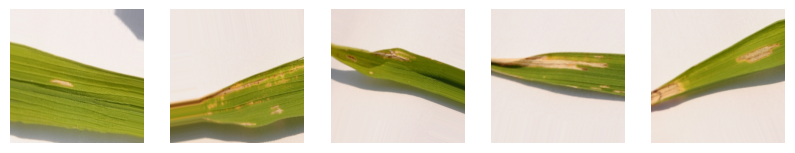

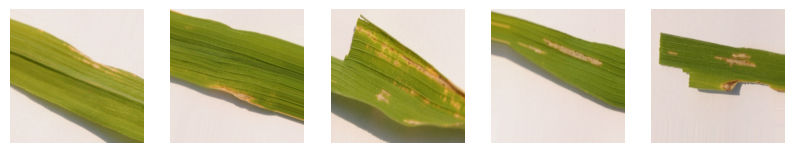

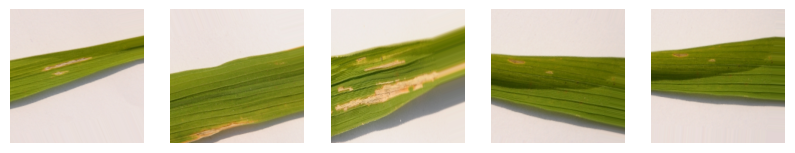

In [25]:
for i in range(3):
    images, labels = next(val_gen)
    plt.figure(figsize=(10, 5))
    for j in range(5):
        plt.subplot(1, 5, j+1)
        plt.imshow(images[j])
        plt.axis('off')
    plt.show()

In [26]:
from PIL import Image

from PIL import Image

corrupted_files = []

# Loop through each class folder and check the images
for c in classes:
    class_path = os.path.join(DATASET_PATH, c)
    for file in os.listdir(class_path):
        file_path = os.path.join(class_path, file)
        try:
            img = Image.open(file_path)
            img.verify()  # Verify if image is corrupted
        except Exception as e:
            corrupted_files.append((file, c))

# Print results
if corrupted_files:
    print("Corrupted images found:")
    for file, c in corrupted_files:
        print(f"File: {file} in class {c}")
else:
    print("No corrupted images found!")


Corrupted images found:
File: Bacterial leaf blight in class train
File: Brown spot in class train
File: Leaf smut in class train
File: Bacterial leaf blight in class val
File: Brown spot in class val
File: Leaf smut in class val
File: Leaf smut in class test
File: Brown spot in class test
File: Bacterial leaf blight in class test


#### 1️⃣ Detects corrupted images → finds unreadable or broken files.
#### 2️⃣ Removes corrupted files → prevents crashes during training/testing.
#### 3️⃣ Checks dataset folders (train/val/test) → ensures every split is clean.
#### 4️⃣ Improves dataset quality → avoids wrong learning due to bad inputs.
#### 5️⃣ Prepares stable dataset → ready for EDA and accurate model training.

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

# 1. Count images per class
class_counts = {}
for folder in classes:
    folder_path = os.path.join(DATASET_PATH, folder)
    class_counts[folder] = len(os.listdir(folder_path))

print("Image count per class:", class_counts)

Image count per class: {'train': 3, 'val': 3, 'test': 3}


#### Plot class distribution

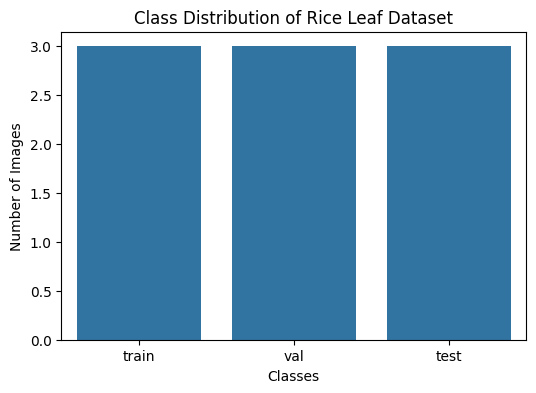

In [28]:
plt.figure(figsize=(6,4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution of Rice Leaf Dataset")
plt.ylabel("Number of Images")
plt.xlabel("Classes")
plt.show()

#### Collect image shapes

In [29]:
img_shapes = []
for folder in classes:
    folder_path = os.path.join(DATASET_PATH, folder)
    for file in os.listdir(folder_path)[:50]:  # check only 50 per class to save time
        img = cv2.imread(os.path.join(folder_path, file))
        if img is not None:
            img_shapes.append(img.shape)

# Show first 10 image shapes
print("Sample image shapes:", img_shapes[:10])

Sample image shapes: []


#### Convert to dataframe-like summary

In [30]:
import pandas as pd
shapes_df = pd.DataFrame(img_shapes, columns=["Height", "Width", "Channels"])
print(shapes_df.describe())

       Height Width Channels
count       0     0        0
unique      0     0        0
top       NaN   NaN      NaN
freq      NaN   NaN      NaN


1️⃣Class Distribution → Are all classes balanced? (e.g., Healthy vs Diseased).

2️⃣Sample Images → Quick sanity check (are images clear, correct?).

3️⃣Image Sizes → See if all images are same size or need resizing before CNN.

👉 This tells you about dataset balance, quality, and preprocessing needs

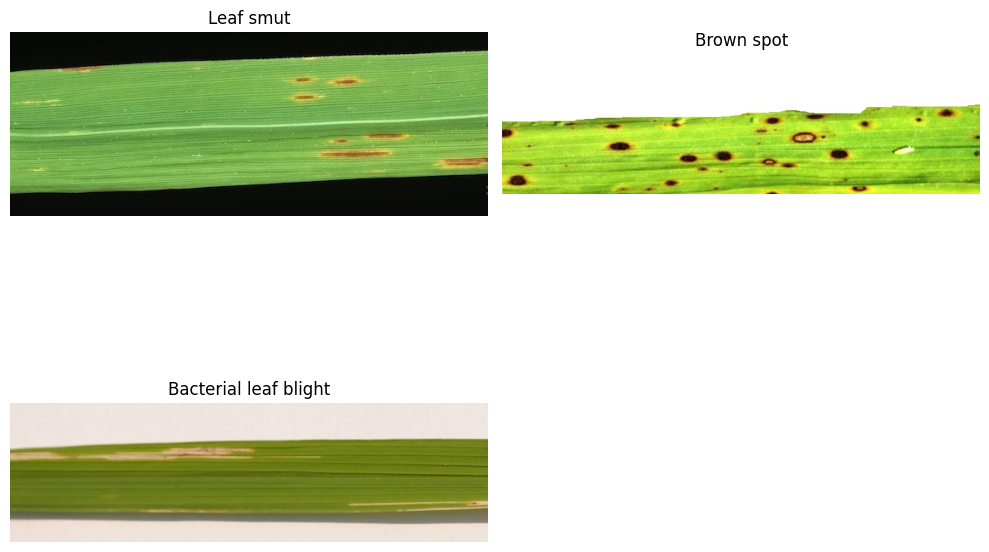

In [31]:
import random
import cv2
import matplotlib.pyplot as plt
import os
plt.figure(figsize=(10,8))

classes_to_visualize = ['Leaf smut', 'Brown spot', 'Bacterial leaf blight']

for i, c in enumerate(classes_to_visualize):
    folder_path = os.path.join(DATASET_PATH, 'test', c)

    if os.path.exists(folder_path) and os.listdir(folder_path):
        file = random.choice(os.listdir(folder_path))
        file_path = os.path.join(folder_path, file)

        img = cv2.imread(file_path)

        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(2, 2, i+1)
            plt.imshow(img)
            plt.title(c)
            plt.axis("off")
        else:
            print(f"Warning: Could not load image {file_path}")
    else:
        print(f"Warning: Class folder not found or is empty: {folder_path}")


plt.tight_layout()
plt.show()

1️⃣Resize & batch: Make all images same size (224×224) and process in small groups (32) for efficiency.

2️⃣Normalize: Convert pixel values to 0–1 so the model learns faster.

3️⃣Augmentation: Randomly rotate, shift, zoom, shear, and flip images to create variety and prevent overfitting.

4️⃣Train/Validation split: Use 80% of images for training and 20% to check model performance.

5️⃣Load from directory: Read images in batches and assign numeric labels for each class.

6️⃣Class mapping: Shows which class corresponds to which number for the model.

In short: Images are prepared, varied, split, and labeled so the CNN can learn efficiently and generalize well

# Model Training

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

### CNN model

In [33]:
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout layer to prevent overfitting
model.add(Dropout(0.25))

# Flatten the feature maps into a vector
model.add(Flatten())

# Fully connected Dense layer
model.add(Dense(128, activation='relu'))

# Dropout layer for regularization
model.add(Dropout(0.5))

# Output layer with softmax activation for classification
model.add(Dense(len(classes), activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model

In [34]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



### Train the model

In [35]:
model_performance = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_steps=val_gen.samples // val_gen.batch_size
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - accuracy: 0.3510 - loss: 9.1238 - val_accuracy: 0.3438 - val_loss: 1.3428
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.3661 - loss: 1.2852 - val_accuracy: 0.3750 - val_loss: 1.0821
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.4728 - loss: 1.0512 - val_accuracy: 0.4688 - val_loss: 1.0337
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.4148 - loss: 1.1068 - val_accuracy: 0.4062 - val_loss: 1.0228
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.4588 - loss: 1.0350 - val_accuracy: 0.5000 - val_loss: 1.0726
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.4371 - loss: 1.0637 - val_accuracy: 0.4375 - val_loss: 1.0093
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.4287 - loss: 1.0542 - val_accuracy: 0.3750 - val_loss: 1.0945
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.4261 - loss: 1.0876 - val_accuracy: 0.5000 - val_loss: 1.0248
Epoch 9/

## Accuracy Garph

In [36]:
print(model_performance.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


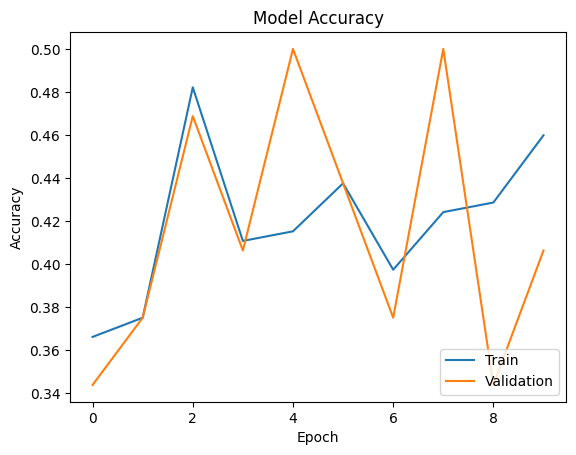

In [37]:
plt.plot(model_performance.history['accuracy'])
plt.plot(model_performance.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

1.Training accuracy is gradually improving overall, which indicates the model is learning from the training data, though there are some ups and downs.

2.Validation accuracy is fluctuating quite a bit — it improves at first, then drops, then rises again — which suggests the model may still need better tuning or more stable training.

3.Toward the later epochs, validation accuracy becomes unstable and suddenly drops, which could be a sign of overfitting or an improper learning rate.

## Loss Graph

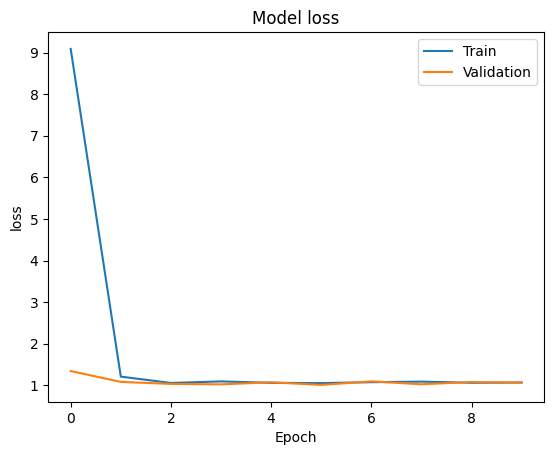

In [38]:
plt.plot(model_performance.history['loss'])
plt.plot(model_performance.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

1.Training loss is steadily decreasing, which shows the model is fitting the training data well.

2.Validation loss initially improves but then shows slight fluctuations, indicating instability and a possible sign of overfitting.

3.To improve the model further, you may need regularization techniques, stronger data augmentation, or learning rate tuning to stabilize validation performance and reduce overfitting.

## Saving the trained model

In [39]:
model.save('rice_leaf_disease_model.h5')

###  Loading the saved model

In [40]:
from tensorflow.keras.models import load_model

In [41]:
model = load_model('rice_leaf_disease_model.h5')

###  image upload to predict

In [79]:
from google.colab import files
from tensorflow.keras.preprocessing import image

upload = files.upload()

img_path = list(upload.keys())[0]
print("uploaded image path:", img_path)

Saving DSC_0293.JPG to DSC_0293.JPG
uploaded image path: DSC_0293.JPG


### Load and preprocessing of image

In [80]:
import numpy as np

img = image.load_img(img_path,target_size=(224,224))

In [81]:
img_array = image.img_to_array(img)

In [82]:
img_array = np.expand_dims(img_array, axis=0)

In [83]:
img_array = img_array / 255.0

### Make Prediction

In [84]:
pred = model.predict(img_array)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [85]:
class_idx = np.argmax(pred)

In [86]:
class_names = ['Bacterial leaf blight' , 'Brown spot','leaf smut']


In [87]:
print("Predicted class:",class_names[class_idx])

Predicted class: Brown spot


In [51]:
test_loss, test_accuracy = model.evaluate(val_gen)
print("Test accuracy:", test_accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 962ms/step - accuracy: 0.4194 - loss: 1.0512
Test accuracy: 0.42592594027519226


# Improved version of model

# Hyper-parameter Tunnning

1.Learning Rate

In [52]:
learning_rates = [0.001, 0.0001, 0.00001]

In [62]:
for lr in learning_rates:
   print(f"\nTraining with learning rate: {lr}")

   model.compile(
       optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
       loss='categorical_crossentropy',
       metrics=['accuracy']
   )

   history = model.fit(
       train_gen,
       validation_data = val_gen,
       epochs=10,
       batch_size= 32,

   )

   val_acc = max(history.history['val_accuracy'])
   print(f"Best validation accuracy: {val_acc}")



Training with learning rate: 0.001
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.4330 - loss: 1.0782 - val_accuracy: 0.4074 - val_loss: 1.0599
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.3660 - loss: 1.0959 - val_accuracy: 0.3148 - val_loss: 1.0715
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.4642 - loss: 1.0330 - val_accuracy: 0.4074 - val_loss: 1.0848
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.4198 - loss: 1.0623 - val_accuracy: 0.3889 - val_loss: 1.0252
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.4246 - loss: 1.0976 - val_accuracy: 0.4074 - val_loss: 1.0557
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.4303 - loss: 1.0725 - val_accuracy: 0.4259 - val_loss: 1.0325
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.4014 - loss: 1.0655 - val_accuracy: 0.4259 - val_loss: 1.0186
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.4255 - loss: 1.0387 - val_accuracy

* From this we can analyze that the 0.00001 learning rate provides the best validation accuracy with 44.4%

### Plot graph accuracy vs epochs and loss vs epoch

In [63]:
import matplotlib.pyplot as plt

### Plot accuracy

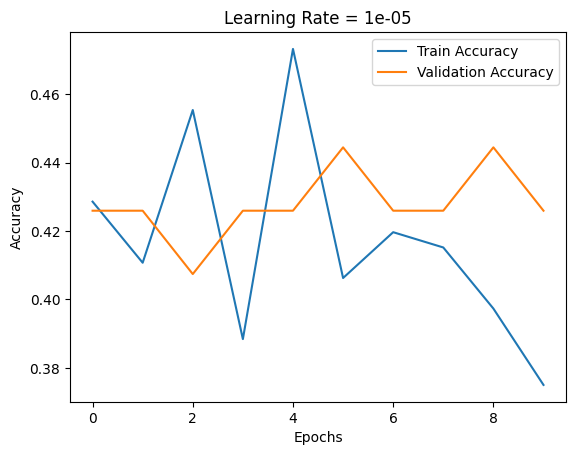

In [64]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f"Learning Rate = {lr}")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [65]:
import matplotlib.pyplot as plt

### Plot loss

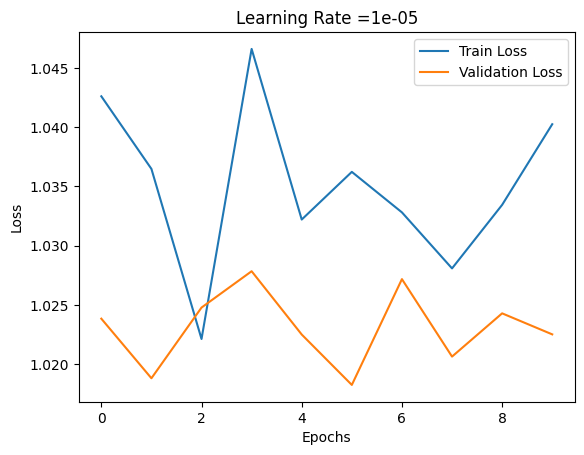

In [66]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f"Learning Rate ={lr}")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 1️⃣ Very small learning rate (1e-5) → Training is slow, so the model is not improving effectively.
#### 2️⃣ Both training and validation loss keep fluctuating → indicates unstable learning and poor convergence.
#### 3️⃣ No clear downward trend in validation loss → model is not generalizing well to unseen data.

## Batch Size tunning

In [73]:
batch_sizes = [16, 32, 64]
learning_rate = 0.00001


In [74]:
for batch_size in batch_sizes:
  print(f"\nTraining with batch size: {batch_size}")


Training with batch size: 16

Training with batch size: 32

Training with batch size: 64


In [75]:
# Recreating the model for experiment weighs
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
    )
base_model.trainable = False


In [76]:
model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(classes), activation='softmax')
    ])

In [77]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [78]:
history = model.fit(
       train_gen,
       validation_data = val_gen,
       epochs=20,
       batch_size= batch_size,

   )
val_acc = max(history.history['val_accuracy'])
print(f"Best validation accuracy for batch size {batch_size}: {val_acc}")


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.3073 - loss: 2.1032 - val_accuracy: 0.2407 - val_loss: 1.7076
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.3272 - loss: 1.8846 - val_accuracy: 0.3889 - val_loss: 1.4900
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.3266 - loss: 1.8255 - val_accuracy: 0.3333 - val_loss: 1.4013
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.3090 - loss: 1.8376 - val_accuracy: 0.4259 - val_loss: 1.3487
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.3660 - loss: 1.6685 - val_accuracy: 0.4074 - val_loss: 1.3024
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.4525 - loss: 1.6057 - val_accuracy: 0.3704 - val_loss: 1.3385
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.2974 - loss: 1.7104 - val_accuracy: 0.3889 - val_loss: 1.2562
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.3911 - loss: 1.4749 - val_accuracy: 0.4259 - val_loss: 1.2422
Epoch 9/

### Data augmentation

In [88]:
import os
import random
import shutil

# Mount Drive if not already mounted
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

# Paths
base_dir = '/content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease Detection/Data'
test_dir = os.path.join(base_dir, 'test')  # Original images folder
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Create train and val directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# List of class folders
classes = ['Leaf smut', 'Brown spot', 'Bacterial leaf blight']  # Adjust according to your dataset

# Create subfolders inside train and val
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

# Train-validation split ratio
train_ratio = 0.75

# Split and move images
for cls in classes:
    cls_test_path = os.path.join(test_dir, cls)
    images = os.listdir(cls_test_path)
    random.shuffle(images)

    train_count = int(len(images) * train_ratio)
    train_images = images[:train_count]
    val_images = images[train_count:]

    print(f"Class '{cls}': {len(train_images)} train and {len(val_images)} val images.")

    # Move train images
    for img in train_images:
        src = os.path.join(cls_test_path, img)
        dst = os.path.join(train_dir, cls, img)
        shutil.copy(src, dst)

    # Move val images
    for img in val_images:
        src = os.path.join(cls_test_path, img)
        dst = os.path.join(val_dir, cls, img)
        shutil.copy(src, dst)

print("Data split completed successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/drive
Class 'Leaf smut': 29 train and 10 val images.
Class 'Brown spot': 30 train and 10 val images.
Class 'Bacterial leaf blight': 30 train and 10 val images.
Data split completed successfully!


In [89]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease Detection/Data/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease Detection/Data/val'


# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data should only be rescaled, no augmentation
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,   # Use the batch size you found best
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

# Get the number of classes
num_classes = len(train_generator.class_indices)

Found 113 images belonging to 3 classes.
Found 54 images belonging to 3 classes.


In [90]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
)


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 14s/step - accuracy: 0.3433 - loss: 1.4087 - val_accuracy: 0.6667 - val_loss: 0.8055
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step - accuracy: 0.5147 - loss: 1.0401 - val_accuracy: 0.6852 - val_loss: 0.6283
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - accuracy: 0.5939 - loss: 0.9001 - val_accuracy: 0.8333 - val_loss: 0.4858
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.7470 - loss: 0.6849 - val_accuracy: 0.7778 - val_loss: 0.4619
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 7s/step - accuracy: 0.8136 - loss: 0.5952 - val_accuracy: 0.8889 - val_loss: 0.3805
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.8158 - loss: 0.4361 - val_accuracy: 0.9074 - val_loss: 0.3258
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.8149 - loss: 0.4199 - val_accuracy: 0.9259 - val_loss: 0.2681
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.8952 - loss: 0.3718 - val_accuracy: 0.9259 - val_loss: 0.2439
Epoch 9

## Adding callbacks and modelcheckpoint

In [91]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[checkpoint, earlystop]
)


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9956 - loss: 0.0373

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step - accuracy: 0.9941 - loss: 0.0406 - val_accuracy: 0.9630 - val_loss: 0.0573
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.9830 - loss: 0.0630 - val_accuracy: 0.9630 - val_loss: 0.0556
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.9442 - loss: 0.1120 - val_accuracy: 0.9630 - val_loss: 0.0567
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9707 - loss: 0.1091

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.9746 - loss: 0.1038 - val_accuracy: 0.9815 - val_loss: 0.0640
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.9814 - loss: 0.0666 - val_accuracy: 0.9815 - val_loss: 0.0673
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.9712 - loss: 0.0699 - val_accuracy: 0.9815 - val_loss: 0.0646
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 7s/step - accuracy: 0.9873 - loss: 0.0790 - val_accuracy: 0.9815 - val_loss: 0.0603


### performance check

In [92]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9630 - loss: 0.0556
Validation Accuracy: 96.30%
Validation Loss: 0.0556


### confusion matrix

In [93]:
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [94]:
y_true = val_generator.classes


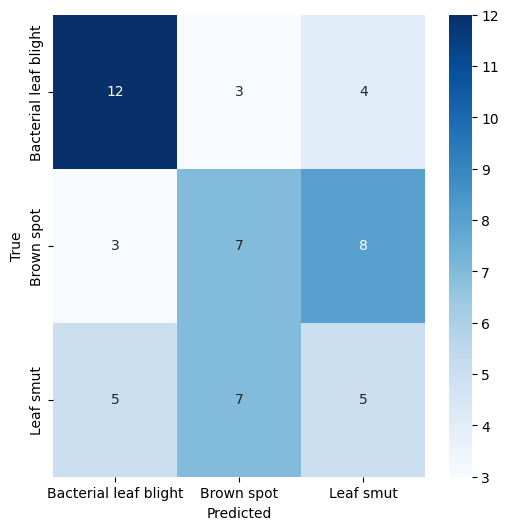

In [95]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Classification report

In [96]:
print(classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys()))


                       precision    recall  f1-score   support

Bacterial leaf blight       0.60      0.63      0.62        19
           Brown spot       0.41      0.39      0.40        18
            Leaf smut       0.29      0.29      0.29        17

             accuracy                           0.44        54
            macro avg       0.44      0.44      0.44        54
         weighted avg       0.44      0.44      0.44        54



## Testing

In [97]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/content/drive/MyDrive/project/PRCP-1001-RiceLeaf/Data/test/Leaf smut/DSC_0317.JPG'  # change to your image
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
classes = list(val_generator.class_indices.keys())
print("Prediction:", classes[np.argmax(prediction)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: Leaf smut


In [98]:
model.save("rice_leaf_disease_model.h5")
# Load later
from tensorflow.keras.models import load_model
loaded_model = load_model("rice_leaf_disease_model.h5")

In [99]:
!pip install gradio

import gradio as gr
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load your saved model
model = tf.keras.models.load_model("rice_leaf_disease_model.h5")

# Class names (must match your dataset classes)
class_names = ['Leaf smut', 'Brown spot', 'Bacterial leaf blight']  # change if more classes

# Prediction function
def predict(img):
    img = img.resize((224, 224))  # resize to model input size
    img_array = image.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return {class_names[i]: float(prediction[0][i]) for i in range(len(class_names))}

# Create Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="Rice Leaf Disease Detection",
    description="Upload a rice leaf image to classify whether it's healthy or diseased."
)

# Launch interface
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fdfef6a9d889698a38.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
